# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import copy
from sklearn.model_selection import train_test_splito

/home/amirabbas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CustomDataSet Class to Make DataSets

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform = A.Compose([A.Resize(128, 128), ToTensorV2()])):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        transformed = self.transform(image = np.array(self.data[idx]), mask = np.array(self.labels[idx]))
        return transformed['image']/255, transformed['mask']/255

# Unet Class to Do Image Loading, Preprocessing, Training Model, Testing Model, Evaluating Model and Showing Data

In [3]:
class Unet:
    def __init__(self, height = 128, width = 128, depth = 3, augment = None, num_epochs=25):
        torch.cuda.empty_cache()
        self.height = height
        self.width = width
        self.augmentation = augment
        self.model = smp.Unet(
                        encoder_name="resnet34",
                        encoder_weights = "imagenet",
                        in_channels=3,        
                        classes=1            
                    )
        for param in self.model.encoder.parameters():
            param.requires_grad = False
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #self.device = 'cpu'
        self.model = self.model.to(self.device)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        self.num_epochs = num_epochs
        self.acc_res = []
        self.loss_res = []
        self.iou_res = []
        self.dice_res = []
        self.acc_res_val = []
        self.loss_res_val = []
        self.iou_res_val = []
        self.dice_res_val = []

    def resize(self, x):
        return torch.tensor(np.array([self.resize_transform(i).numpy() for i in x]))

    def augment(self, x):
        return torch.tensor(np.array([self.augmentation(i).numpy() for i in x]))
    
    def load(self, dir = '/home/amirabbas/Documents/personal/university/8th/deep_learning/archive/kaggle_3m/'):
        dirs = os.listdir(dir)
        dirs.sort()
        x = []
        y = []
        for d in dirs:
            merged = os.path.join(dir, d)
            if not os.path.isfile(merged):
                x_text = []
                y_text = []
                for f in os.listdir(merged):
                    file = os.path.join(merged, f)
                    if '_mask' in file:
                        y_text.append(file)
                    else:
                        new_name = file[:-4]+'_.tif'
                        os.rename(file, new_name)
                        x_text.append(new_name)
                y_text.sort()
                x_text.sort()
                for f in x_text:
                    x.append(Image.open(f))
                for f in y_text:
                    y.append(Image.open(f))
        return x, y   

    def show(self, x, y, tensor = 0, triple = None, dir = './pics/anon'):
        if tensor:
            x.to('cpu')
            y.to('cpu')
            conv = transforms.ToPILImage()
            x = conv(x)
            y = conv(y)
        if triple is not None:
            fig, ax = plt.subplots(1, 3)
            triple.to('cpu')
            triple[triple>=0] = 1
            triple[triple<0] = 0
            triple = conv(triple)
        else:
            fig, ax = plt.subplots(1, 2)
        ax[0].set_yticklabels([])
        ax[0].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].set_xticklabels([])
        if triple != None:
            ax[2].set_yticklabels([])
            ax[2].set_xticklabels([])
        ax[0].imshow(x, cmap = 'gray')
        ax[1].imshow(y, cmap = 'gray')
        if triple != None:
            ax[2].imshow(triple, cmap = 'gray')
        ax[0].set_title('Image')
        ax[1].set_title('Mask')
        if triple != None:
            ax[2].set_title('Predict')
        plt.savefig(dir)
        plt.show() 

    def data_split(self, data, labels, train_size, valid_size, test_size, batch_size = 1, boost = 1):
        data = np.array(data)
        labels = np.array(labels)
        idx = np.random.permutation(len(data))
        data = data[idx]
        labels = labels[idx]
        train_data = data[:int(train_size * len(data))]
        train_label = labels[:int(train_size * len(data))]
        self.train_dataset = CustomDataset(train_data, train_label, self.augmentation)
        test_data = data[int(train_size * len(data)):int(test_size * len(data)) + int(train_size * len(data))]
        test_label = labels[int(train_size * len(data)):int(test_size * len(data)) + int(train_size * len(data))]
        test_dataset = CustomDataset(test_data, test_label)
        val_data = data[int(test_size * len(data)) + int(train_size * len(data)):]
        val_label = labels[int(test_size * len(data)) + int(train_size * len(data)):]
        val_dataset = CustomDataset(val_data, val_label)
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.dataloaders = {'train': self.train_loader, 'test': self.test_loader, 'val': self.valid_loader}
    
    def Dice(self, output, target):
        def mul(inp, tar):
            return np.logical_and(inp, tar)
        A = (target >= 0.5)
        B = (output >= 0)
        fun = np.vectorize(mul)
        C = fun(B.cpu(), A.cpu())
        if A.sum() + B.sum() > 0:
            return 2 * C.sum() / (A.sum() + B.sum())
        else:
            return 1

    def IoU(self, output, target):
        def mul(inp, tar):
            return np.logical_and(inp, tar)
        A = (target >= 0.5)
        B = (output >= 0)
        fun = np.vectorize(mul)
        C = fun(B.cpu(), A.cpu())
        if A.sum() + B.sum() > 0:
            return C.sum() / (A.sum() + B.sum() - C.sum())
        else:
            return 1
    
    def accuracy(self, output, target):
        temp_target = target>=0.5
        temp_output = output>=0
        res = temp_target ^ temp_output
        return (res == 0).sum() / res.numel()

    def train_model(self):
        torch.cuda.empty_cache()
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_loss = float('inf')
        current_loss = float('inf')
        early = False
        for epoch in range(self.num_epochs):
            if early == True:
                break
            print(f'Epoch {epoch}/{self.num_epochs - 1}')
            print('-' * 10)
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                running_loss = 0.0
                running_iou = 0.0
                running_dice = 0.0
                running_acc = 0.0
                for inputs, labels in tqdm(self.dataloaders[phase]):
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device).unsqueeze(1)
                    self.optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs.float(), labels.float())
                        dice = self.Dice(outputs.float(), labels.float())
                        iou = self.IoU(outputs.float(), labels.float())
                        acc = self.accuracy(outputs.float(), labels.float())
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_dice += dice * inputs.size(0)
                    running_iou += iou * inputs.size(0)
                    running_acc += acc * inputs.size(0)
                epoch_loss = running_loss / len(self.dataloaders[phase].dataset)
                epoch_iou = running_iou / len(self.dataloaders[phase].dataset)
                epoch_dice = running_dice / len(self.dataloaders[phase].dataset)
                epoch_acc = running_acc / len(self.dataloaders[phase].dataset)
                if phase == 'train':
                    self.acc_res.append(epoch_acc)
                    self.dice_res.append(epoch_dice)
                    self.loss_res.append(epoch_loss)
                    self.iou_res.append(epoch_iou)
                else:
                    self.acc_res_val.append(epoch_acc)
                    self.dice_res_val.append(epoch_dice)
                    self.loss_res_val.append(epoch_loss)
                    self.iou_res_val.append(epoch_iou)
                print(f'{phase} Loss: {epoch_loss:.4f}')
                print(f'{phase} Dice Score: {epoch_dice:.4f}')
                print(f'{phase} IoU: {epoch_iou:.4f}')
                print(f'{phase} Accuracy: {epoch_acc:.4f}')
                if phase == 'val' and epoch_loss > current_loss:
                        early = True
                        print('Early Stop!')
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                if phase == 'val':
                    current_loss = epoch_loss
        print('Best val loss: {:4f}'.format(best_loss))
        self.model.load_state_dict(best_model_wts)
    

    def test_model(self):
        sum_loss = 0.0
        sum_dice = 0.0
        sum_iou = 0.0
        sum_acc = 0.0
        pred = None
        for inputs, labels in tqdm(self.dataloaders['test']):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device).unsqueeze(1)
            self.optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                if pred == None:
                    pred = outputs
                else:
                    pred = torch.cat((pred, outputs), dim = 0)
                loss = self.criterion(outputs.float(), labels.float())
                dice = self.Dice(outputs.float(), labels.float())
                iou = self.IoU(outputs.float(), labels.float())
                acc = self.accuracy(outputs.float(), labels.float())
                sum_loss += loss * inputs.size(0)
                sum_dice += dice * inputs.size(0)
                sum_iou += iou * inputs.size(0)
                sum_acc += acc * inputs.size(0)
        print('Test Loss:', f"{(sum_loss / len(self.dataloaders['test'].dataset)):.4f}")
        print('Test Dice Score:', f"{(sum_dice / len(self.dataloaders['test'].dataset)):.4f}")
        print('Test IoU:', f"{(sum_iou / len(self.dataloaders['test'].dataset)):.4f}")
        print('Test Accuracy:', f"{(sum_acc / len(self.dataloaders['test'].dataset)):.4f}")
        return pred

# Define How to Augment and Instantiating Object from Unet Calss

In [4]:
train_transform = A.Compose(
    [
        A.Resize(128, 128),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p = 0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.ShiftScaleRotate(),
        A.ElasticTransform(),
        ToTensorV2()
    ]
)
unet = Unet(augment=train_transform)
x, y = unet.load()

# Show Samples of Data

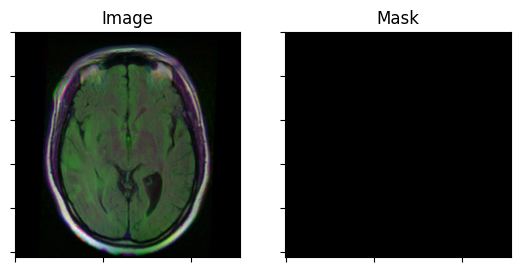

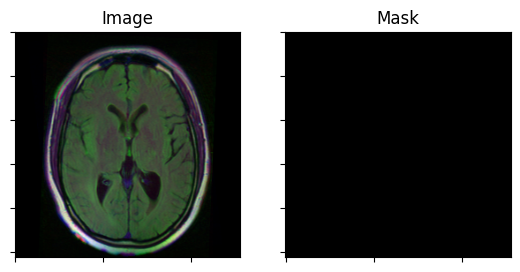

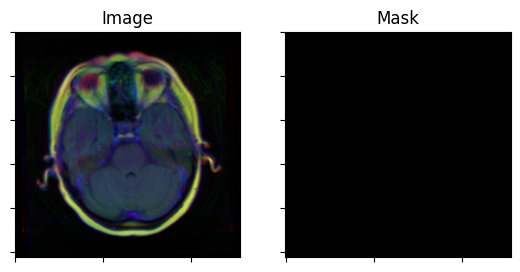

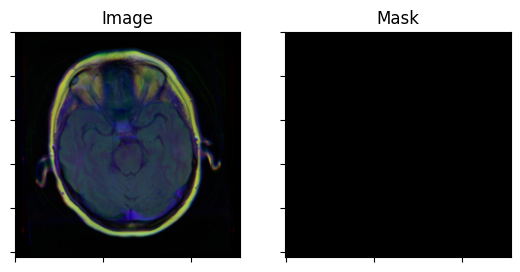

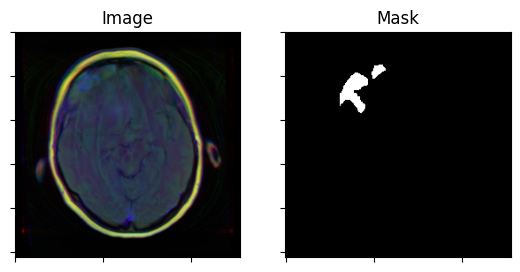

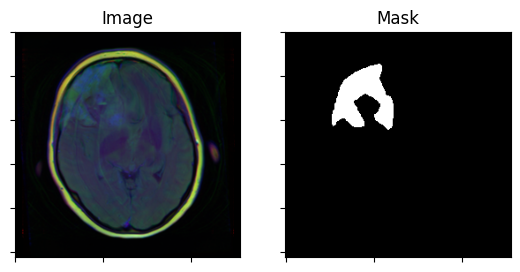

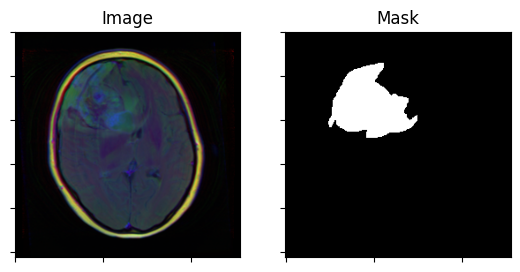

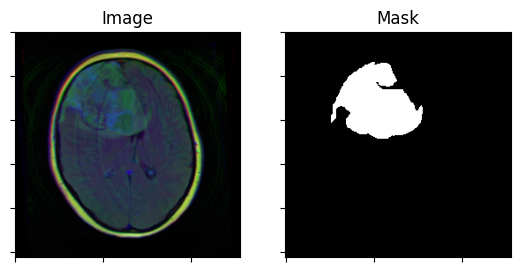

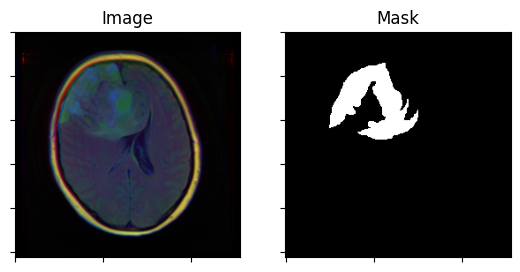

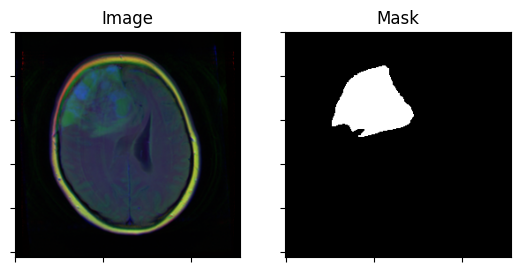

In [5]:
for i in range(121, 131):
    unet.show(x[i], y[i], dir = f'./pics/sample_{i}')

# Split Data

In [6]:
unet.data_split(x, y, 6/8, 1/8, 1/8, 4)

# Show Samples of Augmented Data

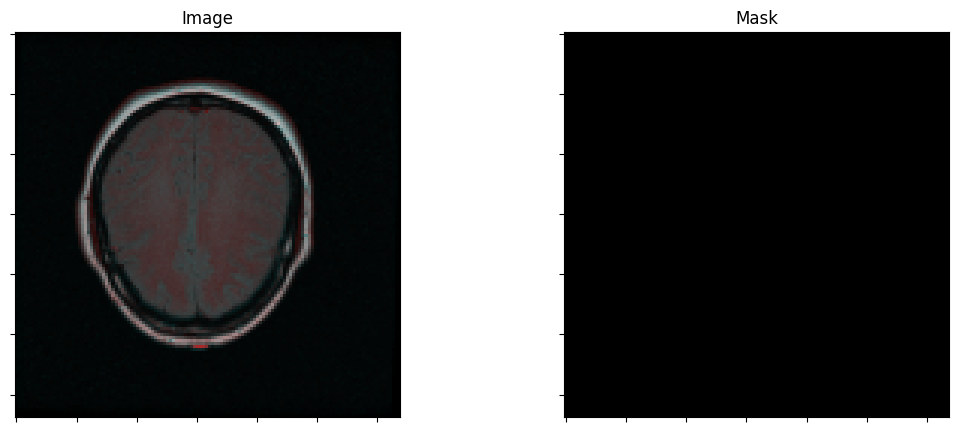

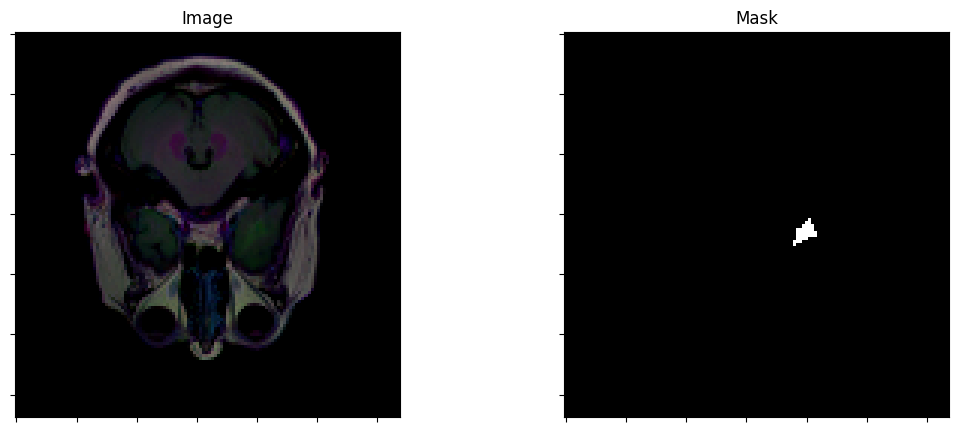

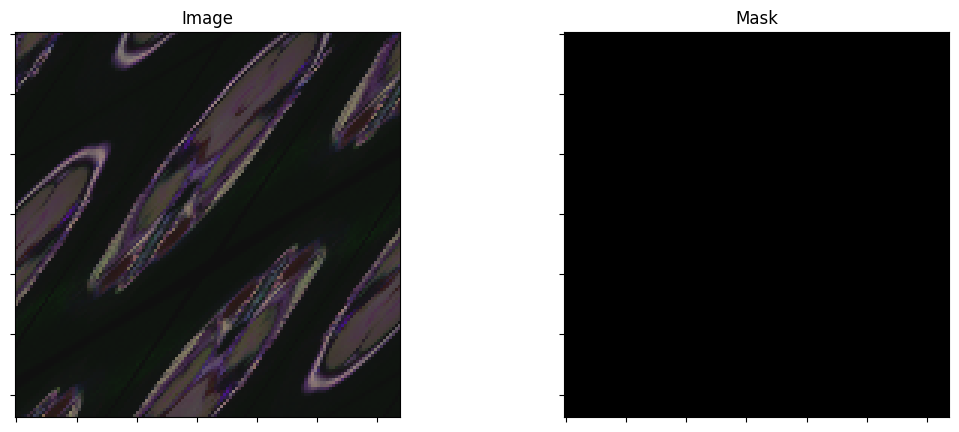

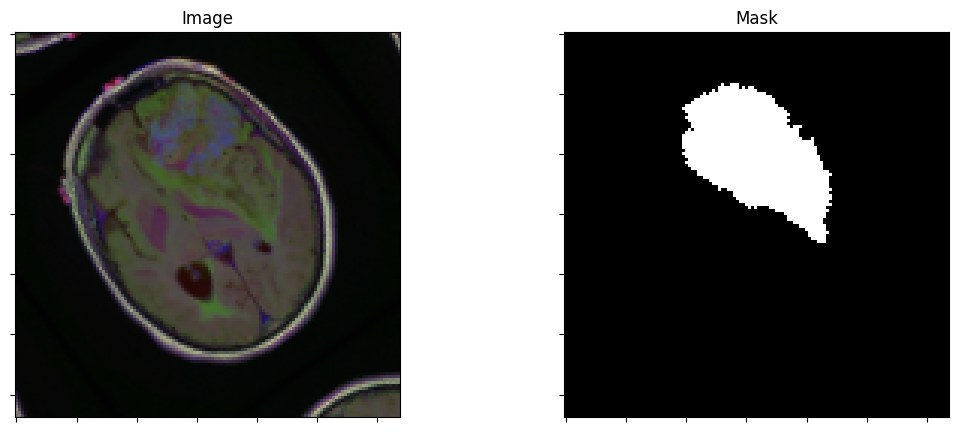

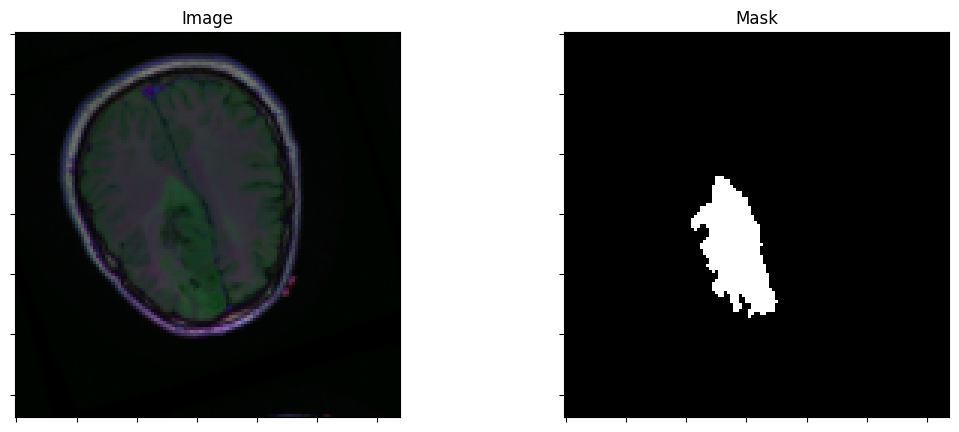

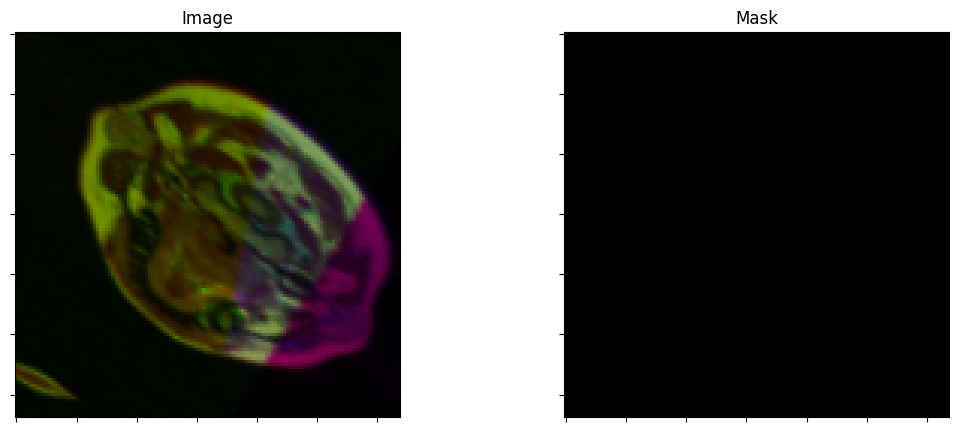

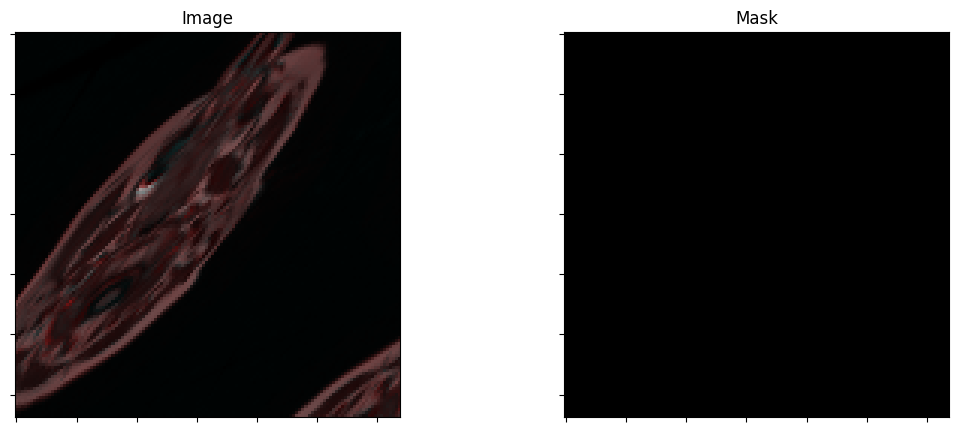

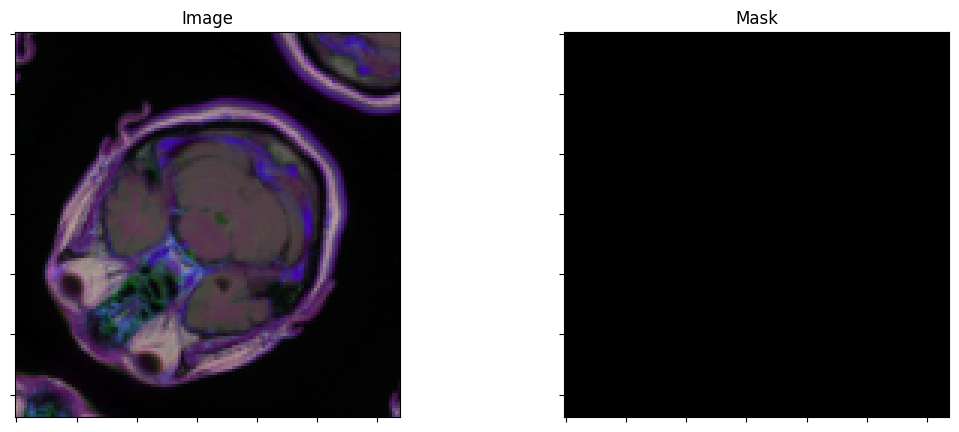

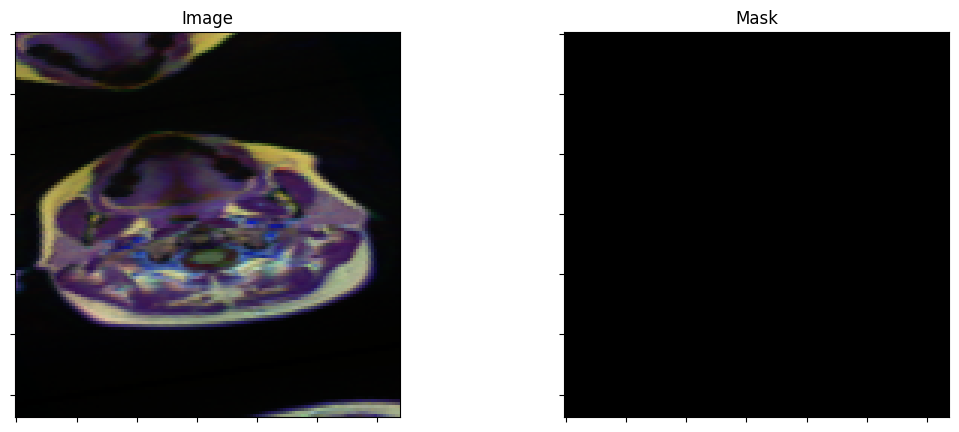

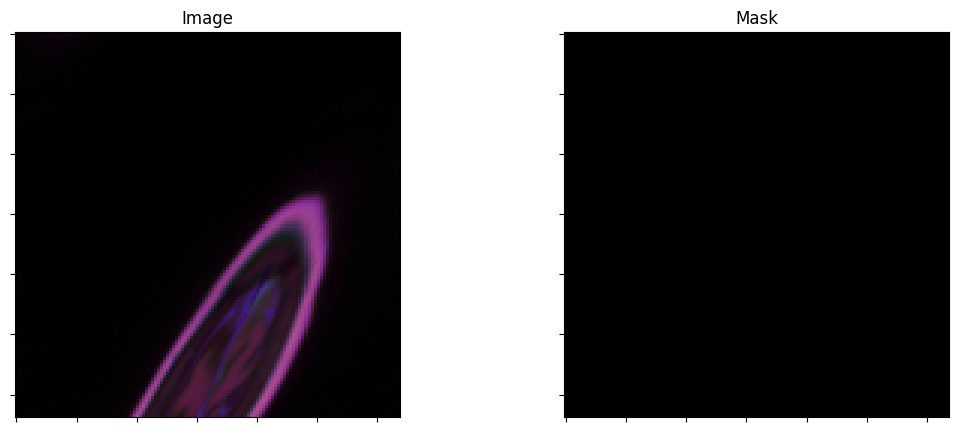

In [29]:
it = iter(unet.train_dataset)
for i in range(40):
    im, lab = next(it)
    if i >= 30:
        unet.show(im, lab, 1, dir=f'pics/aug_{i}')

# Train Model

In [8]:
unet.train_model()

Epoch 0/24
----------


  0%|          | 0/737 [00:00<?, ?it/s]

100%|█████████▉| 736/737 [01:31<00:00,  8.41it/s]/home/amirabbas/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 737/737 [01:31<00:00,  8.07it/s]


train Loss: 0.1783
train Dice Score: 0.2749
train IoU: 0.2198
train Accuracy: 0.9693


100%|██████████| 123/123 [00:09<00:00, 13.18it/s]


val Loss: 0.0567
val Dice Score: 0.4347
val IoU: 0.3644
val Accuracy: 0.9928
Epoch 1/24
----------


100%|██████████| 737/737 [01:25<00:00,  8.62it/s]


train Loss: 0.0447
train Dice Score: 0.4503
train IoU: 0.3604
train Accuracy: 0.9913


100%|██████████| 123/123 [00:09<00:00, 12.84it/s]


val Loss: 0.0284
val Dice Score: 0.4750
val IoU: 0.3922
val Accuracy: 0.9933
Epoch 2/24
----------


100%|██████████| 737/737 [01:29<00:00,  8.24it/s]


train Loss: 0.0306
train Dice Score: 0.4919
train IoU: 0.3990
train Accuracy: 0.9921


100%|██████████| 123/123 [00:09<00:00, 12.48it/s]


val Loss: 0.0203
val Dice Score: 0.5693
val IoU: 0.4818
val Accuracy: 0.9945
Epoch 3/24
----------


100%|██████████| 737/737 [01:27<00:00,  8.44it/s]


train Loss: 0.0260
train Dice Score: 0.5240
train IoU: 0.4342
train Accuracy: 0.9927


100%|██████████| 123/123 [00:12<00:00,  9.62it/s]


val Loss: 0.0177
val Dice Score: 0.6082
val IoU: 0.5141
val Accuracy: 0.9945
Epoch 4/24
----------


100%|██████████| 737/737 [01:26<00:00,  8.55it/s]


train Loss: 0.0234
train Dice Score: 0.5617
train IoU: 0.4670
train Accuracy: 0.9930


100%|██████████| 123/123 [00:09<00:00, 13.02it/s]


val Loss: 0.0177
val Dice Score: 0.5466
val IoU: 0.4627
val Accuracy: 0.9945
Epoch 5/24
----------


100%|██████████| 737/737 [01:26<00:00,  8.50it/s]


train Loss: 0.0215
train Dice Score: 0.5616
train IoU: 0.4694
train Accuracy: 0.9934


100%|██████████| 123/123 [00:09<00:00, 13.09it/s]


val Loss: 0.0140
val Dice Score: 0.6089
val IoU: 0.5266
val Accuracy: 0.9952
Epoch 6/24
----------


100%|██████████| 737/737 [01:27<00:00,  8.45it/s]


train Loss: 0.0204
train Dice Score: 0.5907
train IoU: 0.4951
train Accuracy: 0.9936


100%|██████████| 123/123 [00:09<00:00, 12.92it/s]


val Loss: 0.0125
val Dice Score: 0.6790
val IoU: 0.5866
val Accuracy: 0.9956
Epoch 7/24
----------


100%|██████████| 737/737 [01:27<00:00,  8.44it/s]


train Loss: 0.0182
train Dice Score: 0.6011
train IoU: 0.5069
train Accuracy: 0.9941


100%|██████████| 123/123 [00:09<00:00, 12.55it/s]


val Loss: 0.0124
val Dice Score: 0.6347
val IoU: 0.5481
val Accuracy: 0.9954
Epoch 8/24
----------


100%|██████████| 737/737 [01:26<00:00,  8.53it/s]


train Loss: 0.0188
train Dice Score: 0.5783
train IoU: 0.4845
train Accuracy: 0.9938


100%|██████████| 123/123 [00:09<00:00, 13.64it/s]


val Loss: 0.0123
val Dice Score: 0.6583
val IoU: 0.5699
val Accuracy: 0.9956
Epoch 9/24
----------


100%|██████████| 737/737 [01:20<00:00,  9.19it/s]


train Loss: 0.0174
train Dice Score: 0.6174
train IoU: 0.5244
train Accuracy: 0.9944


100%|██████████| 123/123 [00:08<00:00, 14.19it/s]


val Loss: 0.0104
val Dice Score: 0.7056
val IoU: 0.6169
val Accuracy: 0.9963
Epoch 10/24
----------


100%|██████████| 737/737 [01:17<00:00,  9.52it/s]


train Loss: 0.0178
train Dice Score: 0.6074
train IoU: 0.5150
train Accuracy: 0.9942


100%|██████████| 123/123 [00:08<00:00, 14.06it/s]

val Loss: 0.0119
val Dice Score: 0.6798
val IoU: 0.5948
val Accuracy: 0.9959
Early Stop!
Best val loss: 0.010359


# Test and Predict Model

In [9]:
predict = unet.test_model()

100%|██████████| 123/123 [00:08<00:00, 14.32it/s]

Test Loss: 0.0089
Test Dice Score: 0.7957
Test IoU: 0.7175
Test Accuracy: 0.9967


# Save Model

In [13]:
torch.save(unet.model.state_dict(), './model_unet')

# Show samples of Output of Model

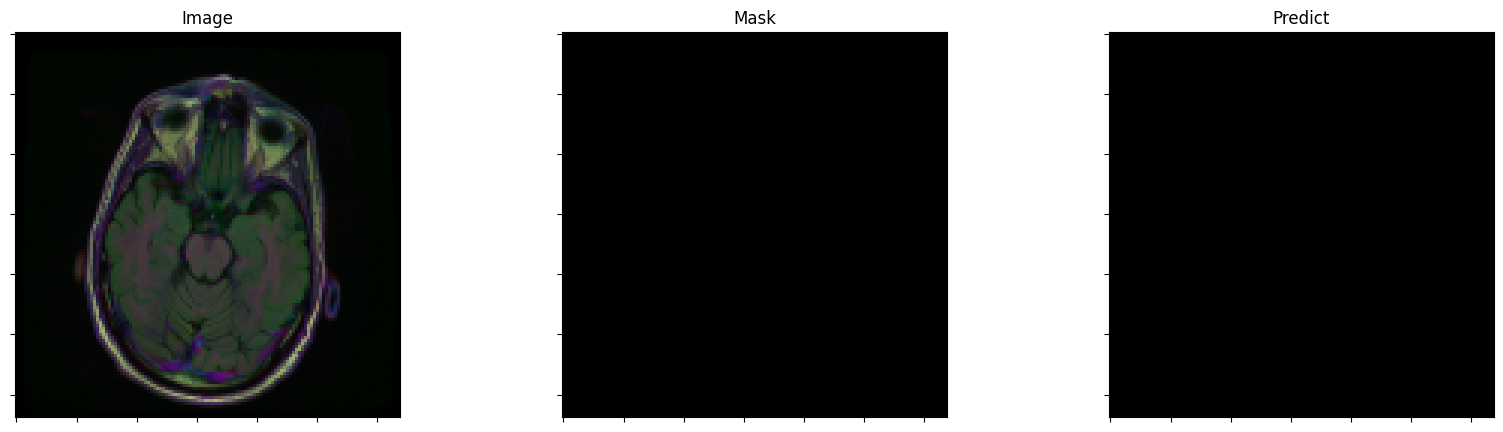

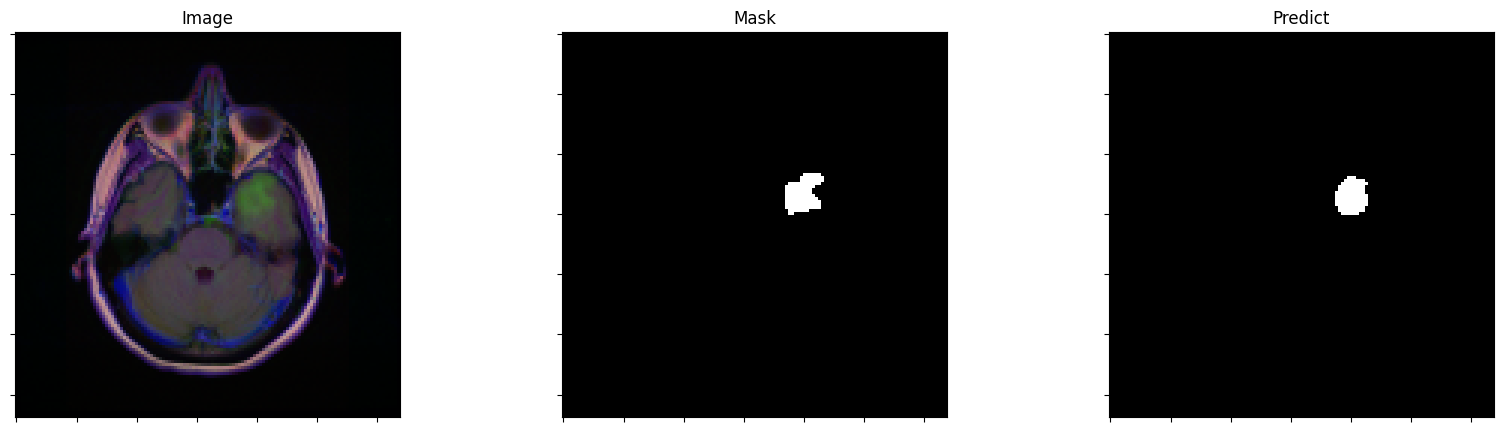

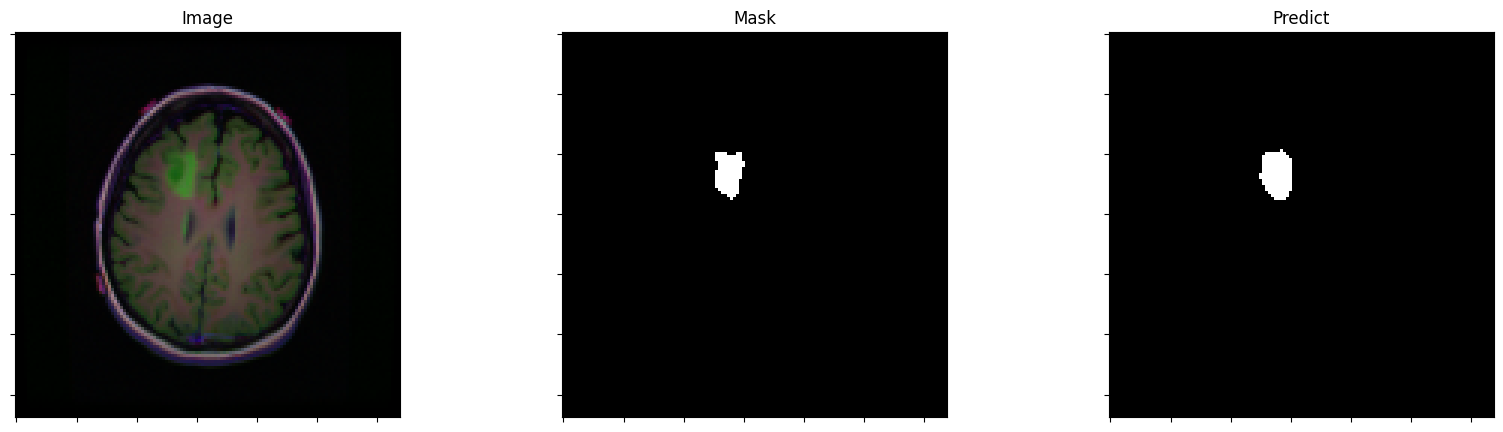

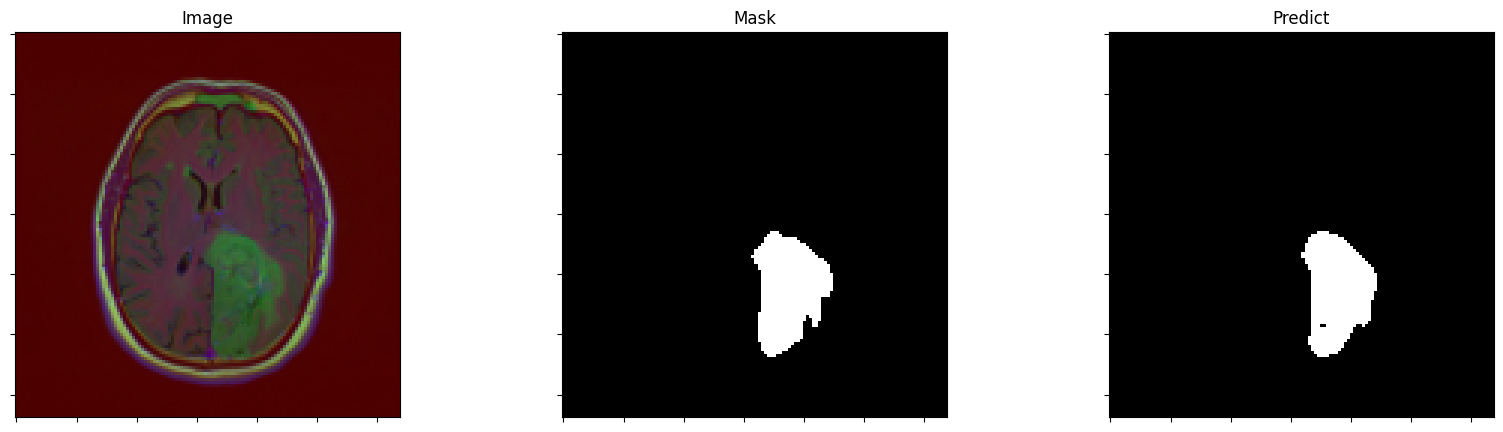

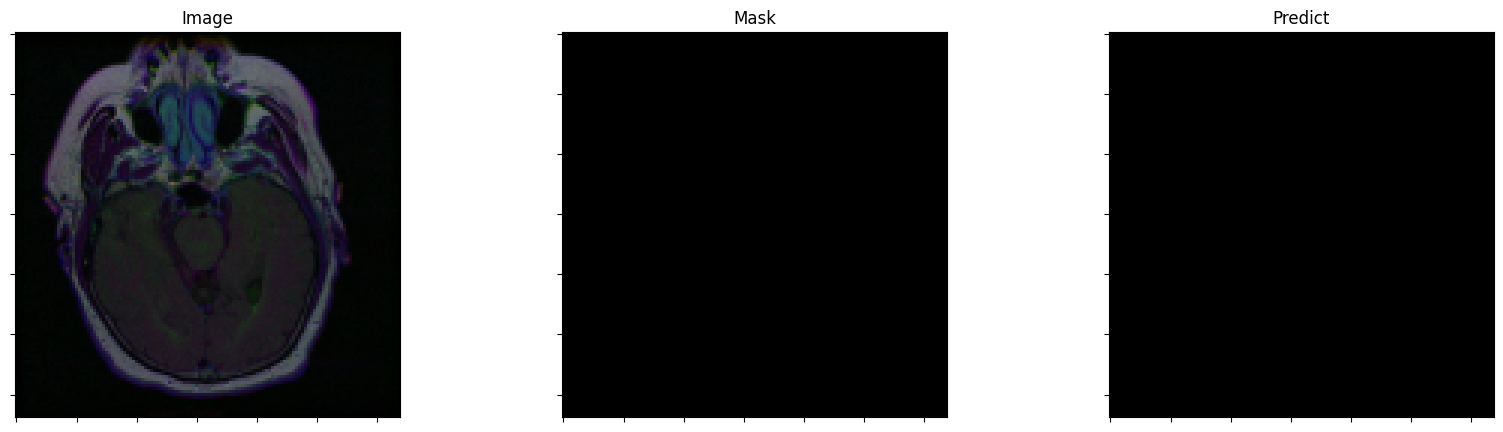

In [23]:
for i in range(20, 25):
    mask =  predict[i]
    image, target = unet.test_loader.dataset[i]
    Unet.show(self = Unet, x = image, y = target, tensor=1, triple=copy.deepcopy(mask), dir = f'./pics/test_{i}')
    

# Graph of Model's Evaluations and Loss

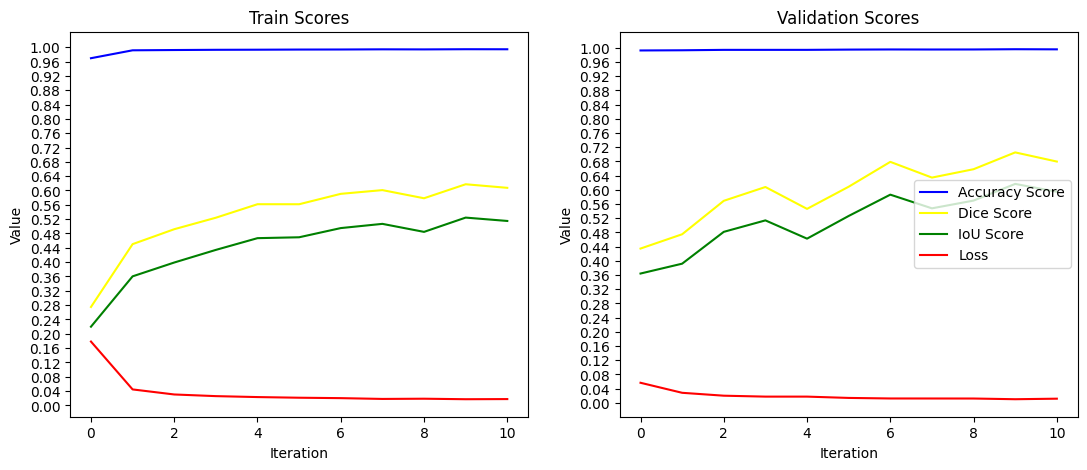

In [30]:
for i in range(len(unet.acc_res)):
    unet.acc_res[i] = unet.acc_res[i].cpu().numpy() if type(unet.acc_res[i]) != np.ndarray else unet.acc_res[i]
    unet.dice_res[i] = unet.dice_res[i].cpu().numpy() if type(unet.dice_res[i]) != np.ndarray else unet.dice_res[i]
    unet.iou_res[i] = unet.iou_res[i].cpu().numpy() if type(unet.iou_res[i]) != np.ndarray else unet.iou_res[i]
    unet.acc_res_val[i] = unet.acc_res_val[i].cpu().numpy() if type(unet.acc_res_val[i]) != np.ndarray else unet.acc_res_val[i]
    unet.dice_res_val[i] = unet.dice_res_val[i].cpu().numpy() if type(unet.dice_res_val[i]) != np.ndarray else unet.dice_res_val[i]
    unet.iou_res_val[i] = unet.iou_res_val[i].cpu().numpy() if type(unet.iou_res_val[i]) != np.ndarray else unet.iou_res_val[i]
    #unet.loss_res[i] = unet.loss_res[i].cpu().numpy() if type(unet.acc_res[i]) != 'numpy.ndarray' else unet.acc_res[i]
fig, ax = plt.subplots(1, 2)
ax[0].plot(unet.acc_res, label = 'Accuracy Score', color = 'blue')
ax[0].plot(unet.dice_res, label = 'Dice Score', color = 'yellow')
ax[0].plot(unet.iou_res, label = 'IoU Score', color = 'green')
ax[0].plot(unet.loss_res, label = 'Loss', color = 'red')
ax[0].set_title('Train Scores')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Value')
ax[1].plot(unet.acc_res_val, label = 'Accuracy Score', color = 'blue')
ax[1].plot(unet.dice_res_val, label = 'Dice Score', color = 'yellow')
ax[1].plot(unet.iou_res_val, label = 'IoU Score', color = 'green')
ax[1].plot(unet.loss_res_val, label = 'Loss', color = 'red')
ax[1].legend(loc = 'center right')
ax[1].set_title('Validation Scores')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Value')
plt.rcParams['figure.figsize'] = [13, 5]
ax[0].set_yticks(np.array(range(0, 102, 4))/100)
ax[1].set_yticks(np.array(range(0, 102, 4))/100)
plt.savefig('plot')
plt.show()